In [19]:
!pip install Sastrawi scikit-learn pandas numpy --quiet

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
import pandas as pd
import numpy as np
import re
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from nltk.corpus import stopwords

In [21]:
# Load dataset ALL
df_all = pd.read_csv("x-data-all.csv", sep=';', encoding='ISO-8859-1')
df_all.head()

,ï»¿komentar,label
0,@IndoPopBase Ratain dulu kualitas sekolah di p...,NaN
1,untuk apa sebenarnya ? Untuk menyelesaikan soa...,NaN
2,kalau mau masukin pelajaran AI untuk kelas se...,NaN
3,padahal dasar semua program Algorthm dan Jari...,NaN
4,@IndoPopBase pelajaran AI : Maksud nya gmn? \n...,NaN


In [22]:
# Load dataset LABELED untuk training model
df = pd.read_csv("x-data-labeled.csv", sep=';', encoding='ISO-8859-1')

# Rename kolom pertama agar jadi "komentar"
df = df.rename(columns={df.columns[0]: "komentar"})

# Ambil hanya kolom komentar + label
df = df[['komentar', 'label']].dropna()

df.head()

,komentar,label
0,@Filosofi_Kucing @tempodotco Tambah2an anak SD...,negative
1,@bunshin_ysf1 @tempodotco saya dari SMP bukan ...,neutral
2,@tempodotco Pelajaran AI coding dini penting? ...,positive
3,"politikus gede bacot semua anj, kemaren kuriku...",negative
4,Kayak gini? Miris! Meja Gibran Cuma Penuh Main...,negative


In [23]:
# ===============================
# STEP 4: Preprocessing Functions
# ===============================
import re
import string
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# stopwords indonesia
stop_words = set(stopwords.words('indonesian'))

# stemmer
stemmer = StemmerFactory().create_stemmer()

# kamus slang
slang_dict = {
    'ga': 'tidak', 'gak': 'tidak', 'nggak': 'tidak', 'ngga': 'tidak',
    'banget': 'sangat', 'bgt': 'sangat', 'kalo': 'kalau', 'gitu': 'begitu',
    'aja': 'saja', 'loh': '', 'deh': '', 'mah': '', 'dah': '', 'cuy': '',
    'anj': 'kasar', 'wkwk': '', 'lol': '', 'btw': '', 'sm': 'sama',
    'pdhl': 'padahal', 'tp': 'tapi', 'sy': 'saya', 'gw': 'saya', 'gue': 'saya',
    'udh': 'sudah', 'sdh': 'sudah', 'dr': 'dari', 'tdk': 'tidak', 'td': 'tidak',
    'tambah2':'tambah-tambah','gin':'gini'
}

# emoji ke label sentimen
emoji_dict = {
    '😡':'negatif', '😢':'negatif', '😭':'negatif', '🤬':'negatif',
    '😍':'positif', '😊':'positif', '😂':'positif', '👍':'positif', '🙏':'positif'
}

# markers untuk deteksi sarkasme
sarcasm_markers = ['banget ya', 'hebat banget', 'ndasmu', 'pintar sekali ya']


def clean_text(text):
    text = str(text).lower()

    # hapus url
    text = re.sub(r"http\S+|www\S+", "", text)

    # hapus mention
    text = re.sub(r"@\w+", "", text)

    # hapus hashtag (#word → word)
    text = re.sub(r"#(\w+)", r"\1", text)

    # hapus tanda baca
    text = re.sub(r"[^\w\s]", "", text)

    # hilangkan huruf berulang (baguuuus → bagus)
    text = re.sub(r"(.)\1{2,}", r"\1", text)

    return text.strip()


def preprocess(text):
    text = clean_text(text)

    # replace slang
    for word, replacement in slang_dict.items():
        text = re.sub(r'\b' + word + r'\b', replacement, text)

    # replace emoji
    for emo, label in emoji_dict.items():
        text = text.replace(emo, label)

    # tokenisasi
    tokens = text.split()

    # hapus stopwords + stemming
    tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and len(t) > 2]

    # tambahkan indikator sarkasme
    for marker in sarcasm_markers:
        if marker in text:
            tokens.append("sarcasm")

    return ' '.join(tokens)

# Terapkan ke dataset labeled
df['clean_text'] = df['komentar'].apply(preprocess)

df.head()

,komentar,label,clean_text
0,@Filosofi_Kucing @tempodotco Tambah2an anak SD...,negative,tambah2an anak kelas bisa coding benerin kurik...
1,@bunshin_ysf1 @tempodotco saya dari SMP bukan ...,neutral,smp hafal provinsi ibukota provinsi indo hafal...
2,@tempodotco Pelajaran AI coding dini penting? ...,positive,ajar coding attitude disiplin tanggung bin waj...
3,"politikus gede bacot semua anj, kemaren kuriku...",negative,politikus gede bacot kasar kemaren kurikulum f...
4,Kayak gini? Miris! Meja Gibran Cuma Penuh Main...,negative,kayak gin miris meja gibran penuh main meja ha...


In [32]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_id'] = df['label'].map(label_map)
df.head()

,ï»¿komentar,label,label_id
0,@Filosofi_Kucing @tempodotco Tambah2an anak SD...,negative,0.0
1,@bunshin_ysf1 @tempodotco saya dari SMP bukan ...,neutral,1.0
2,@tempodotco Pelajaran AI coding dini penting? ...,positive,2.0
3,"politikus gede bacot semua anj, kemaren kuriku...",negative,0.0
4,Kayak gini? Miris! Meja Gibran Cuma Penuh Main...,negative,0.0


In [33]:
df = df.rename(columns={"ï»¿komentar": "komentar"})

In [34]:
df["clean_text"] = df["komentar"].apply(preprocess)

In [35]:
X = df["clean_text"]
y = df["label_id"]

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [38]:
df['label_id'].isna().sum()

np.int64(198)

In [39]:
df[df['label_id'].isna()]


,komentar,label,label_id,clean_text
34,NaN,NaN,NaN,nan
43,NaN,NaN,NaN,nan
44,NaN,NaN,NaN,nan
45,NaN,NaN,NaN,nan
61,NaN,NaN,NaN,nan
...,...,...,...,...
600,NaN,NaN,NaN,nan
601,NaN,NaN,NaN,nan
602,NaN,NaN,NaN,nan
603,NaN,NaN,NaN,nan


In [40]:
df = df.dropna(subset=["komentar", "label"])
df = df.reset_index(drop=True)

In [41]:
df = df.dropna(how="all")
df = df.reset_index(drop=True)

In [42]:
df.isna().sum()

,0
komentar,0
label,0
label_id,0
clean_text,0


In [43]:
df = df.rename(columns={"ï»¿komentar": "komentar"})

In [44]:
label_map = {'negative':0, 'neutral':1, 'positive':2}
df['label_id'] = df['label'].map(label_map)

In [45]:
df = df.dropna(subset=['label_id'])
df['label_id'] = df['label_id'].astype(int)

In [46]:
df['clean_text'] = df['komentar'].apply(preprocess)

In [47]:
# 1. Drop baris yang seluruhnya NaN
df = df.dropna(how="all")

# 2. Drop baris jika komentar atau label kosong
df = df.dropna(subset=["komentar", "label", "clean_text"]).reset_index(drop=True)

# 3. (opsional) lihat ringkasan missing
print("Missing per kolom:\n", df.isna().sum())
print("Jumlah baris setelah bersih:", len(df))

Missing per kolom:
 komentar      0
label         0
label_id      0
clean_text    0
dtype: int64
Jumlah baris setelah bersih: 405


In [48]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# map dan buang yang tidak dikenali
df['label_id'] = df['label'].map(label_map)
print("Jumlah label_id NaN sebelum drop:", df['label_id'].isna().sum())

df = df.dropna(subset=['label_id']).reset_index(drop=True)
df['label_id'] = df['label_id'].astype(int)

# periksa distribusi label
print(df['label'].value_counts())
print(df['label_id'].value_counts())

Jumlah label_id NaN sebelum drop: 0
label
negative    172
positive    124
neutral     109
Name: count, dtype: int64
label_id
0    172
2    124
1    109
Name: count, dtype: int64


In [49]:
X = df['clean_text'].astype(str)   # pastikan tipe string
y = df['label_id']
print("Contoh X:", X.iloc[:3].tolist())
print("Contoh y:", y.iloc[:10].tolist())

Contoh X: ['anak kelas bisaaa coding benerin kurikulum sejahtera didik benerin tuh dibenerin beres usul coding masuk matpel nyocot tok benah', 'smp hafal provinsi ibukota provinsi indo hafal negara ibukotanya amrik', 'ajar coding attitude disiplin tanggung bin wajib minimal biar fufufafa biar pimpinanya bilang ndasmu etik tetap ikhtiar paham generasi bangsa etika sarcasm']
Contoh y: [0, 1, 2, 0, 0, 1, 0, 0, 0, 1]


In [50]:
X = df['clean_text'].astype(str)   # pastikan tipe string
y = df['label_id']
print("Contoh X:", X.iloc[:3].tolist())
print("Contoh y:", y.iloc[:10].tolist())

Contoh X: ['anak kelas bisaaa coding benerin kurikulum sejahtera didik benerin tuh dibenerin beres usul coding masuk matpel nyocot tok benah', 'smp hafal provinsi ibukota provinsi indo hafal negara ibukotanya amrik', 'ajar coding attitude disiplin tanggung bin wajib minimal biar fufufafa biar pimpinanya bilang ndasmu etik tetap ikhtiar paham generasi bangsa etika sarcasm']
Contoh y: [0, 1, 2, 0, 0, 1, 0, 0, 0, 1]


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000, min_df=2, max_df=0.85)
X_tfidf = tfidf.fit_transform(X)
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (405, 990)


In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (324, 990) Test size: (81, 990)


In [53]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import joblib

# Kita pakai pipeline sederhana (scaler tidak berpengaruh besar pada sparse TF-IDF,
# tapi kept for completeness — we won't scale sparse directly).
model = LinearSVC(class_weight='balanced', max_iter=5000, random_state=42)
model.fit(X_train, y_train)

# Save model + tfidf
joblib.dump(model, "svm_tfidf_model.joblib")
joblib.dump(tfidf, "tfidf_vectorizer.joblib")

print("Model terlatih dan disimpan: svm_tfidf_model.joblib, tfidf_vectorizer.joblib")

Model terlatih dan disimpan: svm_tfidf_model.joblib, tfidf_vectorizer.joblib


Accuracy: 0.5679012345679012

Classification Report:
               precision    recall  f1-score   support

    negative       0.62      0.62      0.62        34
     neutral       0.54      0.32      0.40        22
    positive       0.53      0.72      0.61        25

    accuracy                           0.57        81
   macro avg       0.56      0.55      0.54        81
weighted avg       0.57      0.57      0.56        81



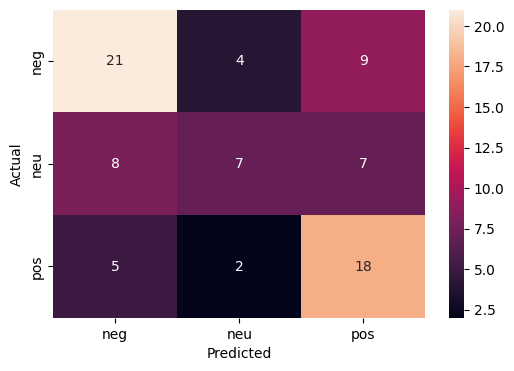

In [54]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['negative','neutral','positive']))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

In [55]:
# kalau X_test adalah sparse matrix, ambil indeks dokumen:
test_indices = y_test.index if hasattr(y_test, 'index') else None

# Untuk kemudahan, kita rebuild small df_test
df_test = df.iloc[y_test.index] if hasattr(y_test, 'index') else None
# fallback: make arrays with original texts by rebuilding from df
# Simpler: create a small list of test texts from splitting earlier:
# (If you have original X and indices, use them. Otherwise reconstruct:)
from scipy.sparse import csr_matrix
# We'll extract strings from original df using stratified split indices is better earlier.
# But to keep simple, show mismatches using predictions on test set with position mapping:
print("Contoh beberapa prediksi salah:")
mis = np.where(y_test.values != y_pred)[0]
for i in mis[:10]:
    print("TRUE:", y_test.values[i], "PRED:", y_pred[i])
    # Find the i-th test text by converting X_test back to strings is complex; skip if unavailable.
    # If you'd like full examples, run train_test_split with return indices earlier to keep mapping.

Contoh beberapa prediksi salah:
TRUE: 1 PRED: 0
TRUE: 0 PRED: 1
TRUE: 1 PRED: 0
TRUE: 1 PRED: 0
TRUE: 2 PRED: 0
TRUE: 1 PRED: 2
TRUE: 1 PRED: 2
TRUE: 1 PRED: 0
TRUE: 1 PRED: 2
TRUE: 2 PRED: 0


In [56]:
# 10.1 load df_all if belum
df_all = pd.read_csv("x-data-all.csv", sep=";", encoding="ISO-8859-1")
# Rename BOM kolom jika perlu
if 'ï»¿komentar' in df_all.columns:
    df_all = df_all.rename(columns={"ï»¿komentar":"komentar"})

# 10.2 drop empty rows
df_all = df_all.dropna(how='all')
df_all = df_all.dropna(subset=['komentar']).reset_index(drop=True)

# 10.3 preprocess
df_all['clean_text'] = df_all['komentar'].astype(str).apply(preprocess)

# 10.4 transform & predict
X_all_tfidf = tfidf.transform(df_all['clean_text'])
pred_all = model.predict(X_all_tfidf)

# 10.5 map back to labels
inv_map = {0:'negative', 1:'neutral', 2:'positive'}
df_all['pred_label_id'] = pred_all
df_all['pred_label'] = df_all['pred_label_id'].map(inv_map)

# 10.6 simpan hasil
df_all.to_csv("x-data-all_with_predictions.csv", index=False, sep=';')
print("Prediksi df_all disimpan ke x-data-all_with_predictions.csv")

Prediksi df_all disimpan ke x-data-all_with_predictions.csv


In [57]:
df.to_csv("x-data-labeled_cleaned.csv", index=False, sep=';')